In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [ ]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [ ]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement= Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [10]:
mindate = session.query(Measurement.date).order_by(Measurement.date.asc()).first()                      
maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [11]:
## Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print("Enter the first search date, between", mindate," ", maxdate)
date1= input("Enter the first search date:")
date1 = datetime.strptime(date1, '%Y-%m-%d').date()
date2 = date1 + dt.timedelta(days=365)
print (date1, date2)

Enter the first search date, between ('2010-01-01',)   ('2017-08-23',)


Enter the first search date: 2016-01-01


2016-01-01 2016-12-31


In [12]:
print(calc_temps(date1,date2))

[(56.0, 74.14421827631008, 84.0)]


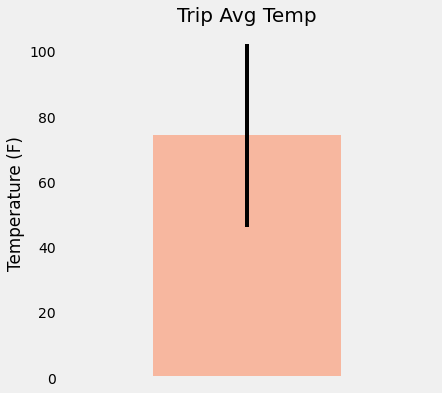

In [13]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
results_df = pd.DataFrame(calc_temps(date1,date2), columns=['tmin', 'tavg', 'tmax'])
yerr = results_df['tmax'] - results_df['tmin']
results_df['tavg'].plot(kind='bar', yerr=yerr, figsize=(6,6), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.grid()
#plt.savefig("Output/TripTempSummary.png")
plt.show()

### Daily Rainfall Average

In [14]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= date1).filter(Measurement.date <= date2).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_df = pd.DataFrame(rainfall, columns=['station', 'latitude','longitude','elevation','tot prcp'])
rainfall_df.set_index('station', inplace=True)
rainfall_df

,latitude,longitude,elevation,tot prcp
station,,,,
"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,162.88
"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,79.89
"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,52.15
"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,30.77
"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,27.29
"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.15
"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.97


In [15]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
#daily_normals("08-01")

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
rangedate= pd.date_range(start_date,end_date, freq='D')
# Strip off the year and save a list of strings in the format %m-%d
listmonthday= rangedate.strftime("%m-%d")
print(listmonthday)
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals=[]
for day in listmonthday:
    normals.append(*daily_normals(day))
    
normals

Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')


[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df['date']=rangedate
df.set_index('date', inplace=True)
df

DatetimeIndex(['2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04',
               '2017-08-05', '2017-08-06', '2017-08-07'],
              dtype='datetime64[ns]', freq='D')


,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


<function matplotlib.pyplot.show(*args, **kw)>

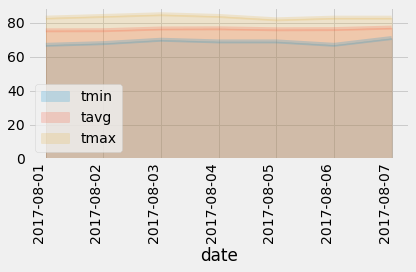

In [39]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area',stacked=False, x_compat=True, alpha=.2, rot=90)
plt.xlabel=("Date")
plt.ylabel=("Temperature")
plt.tight_layout()
plt.show

In [ ]:
# Close Session
session.close()